In [1]:
!python -m pip install --upgrade triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 MB 4.5 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia

In [2]:
import torch

import triton

import triton.language as tl

from triton.runtime import driver

DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [ ]:
def naive_softmax(x):
    x_max = x.max(dim=1)[0]

    z = x-x_max[:, None]
    print(x_max[:, None])

    num = torch.exp(z)

    denm = num.sum(dim=1)

    ret = num/denm[:, None]

    return ret

In [3]:
@triton.jit
def _softmax_kernel(output_ptr, input_ptr, input_row_stride, output_row_stride, n_rows, n_cols,
                    block_size:tl.constexpr,
                    num_stages: tl.constexpr):
    row_start = tl.program_id(0)
    row_step = tl.num_programs(0)
    for row_idx in tl.range(row_start, n_rows, row_step, num_stages=num_stages):
        row_start_ptr = input_ptr + row_idx * input_row_stride
        col_offset = tl.arange(0, block_size)
        input_ptrs = row_start_ptr + col_offset

        mask = col_offset < n_cols
        rows = tl.load(input_ptrs, mask=mask, other=float('-inf'))

        row_stable = rows-tl.max(rows, axis=0)

        num = tl.exp(row_stable)
        denm = tl.sum(num, axis=0)

        output = num/denm

        output_row_start_ptr = output_ptr + row_idx * output_row_stride
        output_ptrs = output_row_start_ptr + col_offset
        tl.store(output_ptrs, output, mask=mask)

In [4]:
properties = driver.active.utils.get_device_properties(DEVICE.index)
NUM_SM = properties["multiprocessor_count"]
NUM_REGS = properties["max_num_regs"]
SIZE_SMEM = properties["max_shared_mem"]
WARP_SIZE = properties["warpSize"]
target = triton.runtime.driver.active.get_current_target()
kernels = {}

In [9]:
def softmax(x: torch.Tensor):
    n_rows, n_cols = x.shape

    block_size = triton.next_power_of_2(n_cols)

    num_warps = 8

    num_stages = 4 if SIZE_SMEM > 200000 else 2

    y = torch.empty_like(x)

    kernel = _softmax_kernel.warmup(y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size=block_size, num_stages=num_stages, num_warps=num_warps,
                                    grid=(1,))

    kernel._init_handles()

    n_regs = kernel.n_regs

    size_smem = kernel.metadata.shared

    occupancy = NUM_REGS // (n_regs * WARP_SIZE * num_warps)
    occupancy = min(occupancy, SIZE_SMEM // size_smem)
    num_programs = NUM_SM * occupancy

    num_programs = min(num_programs, n_rows)

    kernel[(num_programs, 1, 1)](y, x, x.stride(0), y.stride(0), n_rows, n_cols, block_size, num_stages)
    return y


In [11]:
torch.manual_seed(0)
x = torch.randn(1823, 781, device=DEVICE)
y_triton = softmax(x)
y_torch = torch.softmax(x, axis=1)
print(torch.allclose(y_triton, y_torch), (y_triton, y_torch))

True (tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
         1.1834e-03],
        [6.7911e-04, 8.1645e-04, 6.9066e-04,  ..., 1.4361e-04, 9.6084e-04,
         2.5547e-03],
        [5.7850e-04, 9.4147e-04, 1.1231e-04,  ..., 3.4419e-03, 3.8817e-03,
         1.3192e-03]], device='cuda:0'), tensor([[3.2747e-04, 5.3954e-04, 5.8687e-05,  ..., 5.5490e-04, 2.0330e-04,
         9.4091e-04],
        [8.6914e-04, 1.1075e-03, 1.0202e-04,  ..., 1.1470e-04, 5.5436e-04,
         8.6046e-04],
        [1.4101e-03, 1.0511e-03, 1.7031e-03,  ..., 1.2272e-03, 7.9059e-04,
         3.2380e-04],
        ...,
        [1.0722e-04, 3.6355e-04, 4.1703e-04,  ..., 3.5171e-04, 3.4261e-03,
 

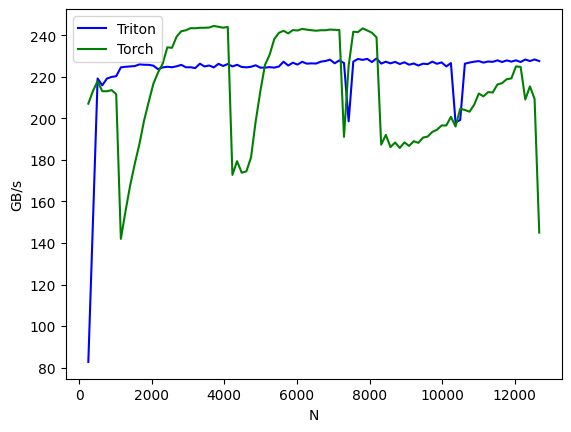

softmax-performance:
          N      Triton       Torch
0     256.0   82.743992  207.116020
1     384.0  150.470105  213.271810
2     512.0  219.214493  217.909681
3     640.0  215.934990  213.101812
4     768.0  219.171573  213.063760
5     896.0  219.972864  213.633046
6    1024.0  220.332316  211.656876
7    1152.0  224.575083  142.005537
8    1280.0  224.856683  155.308043
9    1408.0  225.046862  167.733821
10   1536.0  225.202008  178.206291
11   1664.0  226.023359  187.774737
12   1792.0  225.835391  199.020976
13   1920.0  225.797487  208.059728
14   2048.0  225.394839  216.719641
15   2176.0  223.691176  222.111645
16   2304.0  224.568447  226.377149
17   2432.0  224.876234  234.234902
18   2560.0  224.639857  233.994782
19   2688.0  225.084674  239.394920
20   2816.0  225.777748  241.997302
21   2944.0  224.609556  242.445016
22   3072.0  224.643912  243.454967
23   3200.0  224.235722  243.414814
24   3328.0  226.349397  243.633871
25   3456.0  225.012731  243.653827
26   35

In [12]:
#Benchmark code borrowed from Triton Docs

@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 100)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['triton', 'torch'],  # possible values for `line_arg``
        line_names=[
            "Triton",
            "Torch",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="softmax-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    x = torch.randn(M, N, device=DEVICE, dtype=torch.float32)
    stream = getattr(torch, DEVICE.type).Stream()
    getattr(torch, DEVICE.type).set_stream(stream)
    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.softmax(x, axis=-1))
    if provider == 'triton':
        ms = triton.testing.do_bench(lambda: softmax(x))
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms)


benchmark.run(show_plots=True, print_data=True)